##### <img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Predictive analytics</center>
# Challenge S4: Modelos regresivos - Predicción bursátil

## Objetivo

El objetivo de este challenge es utilizar las técnicas de regresión aprendidas mediante un ejemplo de predicción bursátil.

## 1. Configuración del entorno

Cargamos los paquetes que vamos a utilizar en la sesión.

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

## 2. Análisis de los datos de partida

En este caso vamos a utilizar un dataset obtenido de Yahoo finance, en el que se incluye la cotización del índice del IBEX desde su origen:
https://es.finance.yahoo.com/quote/%5EIBEX/history?p=%5EIBEX



**Carga el fichero IBEX.csv y analiza sus datos.**
 - **¿Qué variables tenemos?**
 - **¿Hay valores nulos? ¿A qué se deben esos valores? **

In [4]:
## Lectura del dataframe
ibex = pd.read_csv("IBEX.csv", na_values='null')

In [5]:
ibex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6587 entries, 0 to 6586
Data columns (total 7 columns):
Date         6587 non-null object
Open         6450 non-null float64
High         6450 non-null float64
Low          6450 non-null float64
Close        6450 non-null float64
Adj Close    6450 non-null float64
Volume       6450 non-null float64
dtypes: float64(6), object(1)
memory usage: 360.3+ KB


In [6]:
ibex.head()

Date         Open         High          Low        Close  \
0  1993-07-06  2814.899902  2829.699951  2814.899902  2818.000000   
1  1993-07-07  2818.000000  2821.500000  2799.000000  2818.699951   
2  1993-07-08  2823.199951  2840.199951  2823.199951  2832.800049   
3  1993-07-09  2832.800049  2844.000000  2822.399902  2830.800049   
4  1993-07-12  2826.800049  2826.800049  2814.600098  2826.399902   

     Adj Close  Volume  
0  2817.997070     0.0  
1  2818.697021     0.0  
2  2832.797119     0.0  
3  2830.797119     0.0  
4  2826.396973     0.0

In [7]:
## Vamos a ver qué días tienen valores nulos
ibex[ibex['Close'].isnull()].tail()

Date  Open  High  Low  Close  Adj Close  Volume
3059  2005-03-28   NaN   NaN  NaN    NaN        NaN     NaN
3254  2005-12-26   NaN   NaN  NaN    NaN        NaN     NaN
3514  2007-01-01   NaN   NaN  NaN    NaN        NaN     NaN
3766  2007-12-24   NaN   NaN  NaN    NaN        NaN     NaN
6069  2017-01-02   NaN   NaN  NaN    NaN        NaN     NaN

In [8]:
## Estos días se corresponden con los días de cierre de la bolsa

## 3. Transformación del dataset

Vamos a adaptar nuestros datos de entrada a un dataset con el que poder trabajar. Para ello vamos a crear nuestro atributo X y nuestra variable y.

- **ibex_X**: variable de tipo índice para la fecha --> Vamos a crear una variable OffsetDays resultado de la diferencia entre la fecha y el primer día de nuestro dataframe. Previamente debemos eliminar los valores nulos de esta variable y convertirla al tipo fecha si queremos hacer la resta de dos fechas.
   Notas: 
       - Para pasar un timedelta a entero en días se puede usar serie.dt.days, donde serie es la serie que queremos convertir.
       - `sklearn` espera que los atributos vengan en un array 2d aunque tengan sólo una columna, por eso es preciso transformarlos a una matriz 2D.
- **ibex_y**: valor de cierre de la acción

** Crea el dataset con las indicaciones anteriores**

In [9]:
## Eliminamos los valores null que se corresponden con días de cierre de la bolsa
ibex = ibex.dropna()

In [10]:
## Comprobamos
ibex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6450 entries, 0 to 6586
Data columns (total 7 columns):
Date         6450 non-null object
Open         6450 non-null float64
High         6450 non-null float64
Low          6450 non-null float64
Close        6450 non-null float64
Adj Close    6450 non-null float64
Volume       6450 non-null float64
dtypes: float64(6), object(1)
memory usage: 403.1+ KB


In [11]:
from datetime import date
## Convertir campo fecha para facilitar las operaciones

ibex['Date'] = pd.to_datetime(ibex['Date'], format='%Y-%m-%d').dt.date
## Calcular índice como la diferencia entre esta fecha y el primer día del dataframe
ibex['OffsetDays'] = ibex['Date'] - date(1993, 7, 6)
ibex['OffsetDays'] = ibex['Date'] - ibex['Date'].iloc[0]
ibex['OffsetDays'] = ibex['OffsetDays'].dt.days

In [12]:
ibex.head()

Date         Open         High          Low        Close  \
0  1993-07-06  2814.899902  2829.699951  2814.899902  2818.000000   
1  1993-07-07  2818.000000  2821.500000  2799.000000  2818.699951   
2  1993-07-08  2823.199951  2840.199951  2823.199951  2832.800049   
3  1993-07-09  2832.800049  2844.000000  2822.399902  2830.800049   
4  1993-07-12  2826.800049  2826.800049  2814.600098  2826.399902   

     Adj Close  Volume  OffsetDays  
0  2817.997070     0.0           0  
1  2818.697021     0.0           1  
2  2832.797119     0.0           2  
3  2830.797119     0.0           3  
4  2826.396973     0.0           6

In [13]:
## Tomamos como atributo X la variable OffsetDays que hemos creado
ibex_X = ibex.OffsetDays.values
ibex_X

array([   0,    1,    2, ..., 9318, 9319, 9320])

In [14]:
## Los transformamos a una matriz 2D.
ibex_X = ibex_X.reshape(ibex_X.shape[0], -1)

In [15]:
## Comprobamos
ibex_X.shape

(6450, 1)

In [16]:
## Como variable y utilizaremos el valor de cierre de la acción
ibex_y = ibex.Close.values
ibex_y.shape

(6450,)

In [17]:
ibex.head()

Date         Open         High          Low        Close  \
0  1993-07-06  2814.899902  2829.699951  2814.899902  2818.000000   
1  1993-07-07  2818.000000  2821.500000  2799.000000  2818.699951   
2  1993-07-08  2823.199951  2840.199951  2823.199951  2832.800049   
3  1993-07-09  2832.800049  2844.000000  2822.399902  2830.800049   
4  1993-07-12  2826.800049  2826.800049  2814.600098  2826.399902   

     Adj Close  Volume  OffsetDays  
0  2817.997070     0.0           0  
1  2818.697021     0.0           1  
2  2832.797119     0.0           2  
3  2830.797119     0.0           3  
4  2826.396973     0.0           6

In [18]:
ibex_X

array([[   0],
       [   1],
       [   2],
       ...,
       [9318],
       [9319],
       [9320]])

**¿Por qué no utilizamos el índice del propio dataframe en vez del campo que hemos calculado (OffsetDays)?**

## 4. Preprocesamiento de los datos

En este caso para hacer un poco más completo el análisis vamos a realizar un paso previo que resulta recomendable siempre que hagamos una regresión y es la normalización.

Normalizar una variable consiste en transformar dicha variable de manera que su media sea 0 ($\mu = 0$) y su desviación tipica 1 ($\delta = 1$)

$$X_{norm} = \frac{X_i - \mu}{\delta}$$

La normalización es necesaria en muchos algoritmos porque:

* Nos permite trabajar con un rango de datos controlado de manera que no perdamos precisión en las operaciones
* La variables están centradas, luego eliminamos sesgos en los datos 
* Algunos modelos realizan asunciones sobre la distribución de la entrada de los datos

Con `sklearn` normalizar es muy sencillo:

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(ibex_X)
ibex_X_scaled = scaler.transform(ibex_X)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
print(ibex_X_scaled)

[[-1.74187662]
 [-1.74150489]
 [-1.74113317]
 ...
 [ 1.7218299 ]
 [ 1.72220163]
 [ 1.72257335]]


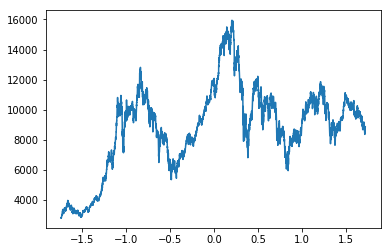

In [21]:
## Vemos los resultados
plt.plot(ibex_X_scaled, ibex_y)

## 5. Evaluación

Una vez que tenemos los datos adaptados al formato adecuado podemos empezar a entrenar modelos. Como siempre, antes de empezar con el conjunto de test, suele ser conveniente entrenar el modelo y evaluarlo con el propio conjunto de entrenamiento, para ello vamos a crear una función similar a la que usamos en el worksheet para entrenar, predecir y representar los resultados.

**Completa la función evalua_modelo**

In [22]:
def evalua_modelo(modelo, X_train, X_test, y_train, y_test):
    
    ## Entrenamiento del modelo
    modelo.fit(X_train, y_train)
    
    ## Predicción sobre el conjunto de entrenamiento
    y_pred_train = modelo.predict(X_train)
    
    ## Evaluación sobre el conjunto de entrenamiento
    score_train = modelo.score(X_train, y_train)
    
    ## Predicción sobre el conjunto de test
    y_pred_test = modelo.predict(X_test)
    ## Evaluación sobre el conjunto de entrenamiento
    score_test = modelo.score(X_test, y_test)
    
    ## Representación de los resultados
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20,6))
    
    ax1.plot(X_train, y_train, 'o', label='Train')
    ax1.plot(X_train, y_pred_train, '*', label='Prediction')
    ax1.set_title('Conjunto de entrenamiento (Score %.2f)' % score_train)
    ax1.legend()
   
    ## Representa resultados
    ax2.plot(X_test, y_test, 'o',color='green',label='Test')
    ax2.plot(X_test, y_pred_test, '*',color='darkorange',label='Prediction')
    ax2.legend()
    ax2.set_title('Conjunto de test (Score %.2f)' % score_test)
    
    f.show()
    
    return modelo

**Separa el dataset en conjunto de entrenamiento y test**

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ibex_X_scaled, ibex_y, test_size=0.1, random_state=42, shuffle=False)

**Utiliza al menos dos modelos de los vistos en la sesión anterior para entrenar y comparar los resultados. **
- **¿Qué score has conseguido?**
- **¿Qué modelo has elegido? ¿Por qué?**


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


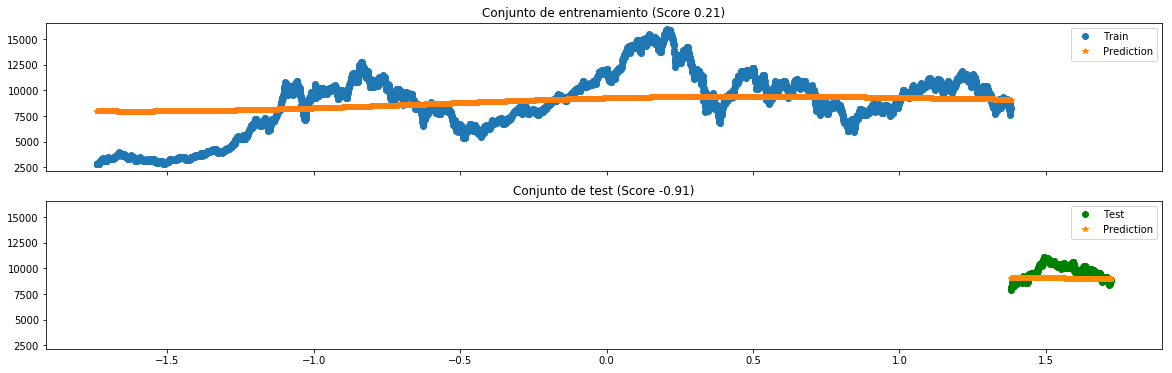

In [24]:
modelo1 = evalua_modelo(SVR(), X_train, X_test, y_train, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


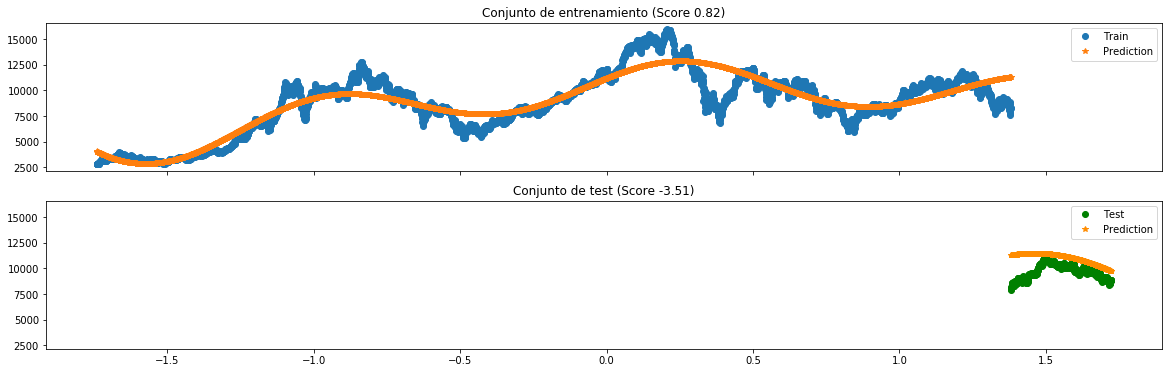

In [25]:
modelo2 = evalua_modelo(SVR(C=2000), X_train, X_test, y_train, y_test)

In [26]:
modelo3 = evalua_modelo(SVR(C=10000), X_train, X_test, y_train, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


## 6. Predicción

Para los modelos anteriores, **realiza una predicción a futuro, por ejemplo, ¿qué ocurrirá dentro de 30 días?**

**Según tus resultados, ¿deberíamos comprar o vender acciones a día de hoy?**
- Compramos si el valor predicho es mayor al valor actual, es decir, las acciones van a subir.
- Vendemos si el valor predicho es menor al valor actual, es decir, las acciones vana a bajar.


In [33]:
## Vamos a hacer una predicción para dentro de un mes
dias = 30
pos_actual = int(ibex_X[-1][0])
x_pred = scaler.transform([[pos_actual+dias]])
y_pred = modelo2.predict(x_pred)
print('Valor predicho: {}'.format(y_pred[0]))
print('Valor actual: {}'.format(ibex_y[-1]))

Valor predicho: 9586.469552133036
Valor actual: 8877.099609


In [34]:
type(x_pred)

numpy.ndarray

**¿Qué puedes decir de la predicción? ¿Tenemos la misma situación en 1993 que en 2019?**

## 7. Predicción mejorada

Vamos a hacer una predicción mejorada, para ello, vamos a usar un procesamiento de la información en ventanas: Por cada elemento de la serie, entrena un regresor con un conjunto de datos de tamaño "long_ventana_entrenamiento" y realiza una predicción a "prediccion_a_n_dias".

In [28]:
def procesa_en_ventanas(regressor, X, y, long_ventana_entrenamiento, prediccion_a_n_dias):
    '''
    Por cada elemento de la serie, entrena un regresor con un conjunto de datos de tamaño
    "long_ventana_entrenamiento" y realiza una predicción a "prediccion_a_n_dias"
    
    Obtiene como entrada:
    * Modelo de regresión
    * Vectores X e y
    * Tamaño de la ventana de entrenamiento
    * N de días a realizar la predicción
    
    Devuelve 4 listas con un punto cada predicción:
    * pos_actual: posición actual de la serie
    * valor_actual: valor actual de la serie
    * pos_pred: posición predicha de la serie (pos_actual + prediccion_a_n_dias)
    * valor_pred: valor predicho de la serie
    
    Por ejemplo: procesa_en_ventanas(SVR(C=5), ibex_X, ibex_y, 60, 30) por cada punto de la 
    serie entrena un modelo con los 60 últimos días y realiza una predicción a 30 días.
    '''
   
    ## Inicialización de variables
    pos_actual = []
    valor_actual = []
    pos_pred = []
    valor_pred = []
    
    inicio_serie = long_ventana_entrenamiento
    fin_serie = X.shape[0] - (prediccion_a_n_dias + 1)
    
    for i in range(inicio_serie, fin_serie):
        
        ## Ventana de entrenamiento
        ini_train = i - long_ventana_entrenamiento
        fin_train = i
        ventana_X_train = X[ini_train : fin_train]
        ventana_y_train = y[ini_train : fin_train]
        
        ## Predicción a n días
        pos_test = i + prediccion_a_n_dias
        ventana_X_test = X[pos_test : pos_test + 1]
        ventana_y_test = y[pos_test : pos_test + 1]

        ## Entrenamos nuestro modelo
        regressor.fit(ventana_X_train, ventana_y_train)
        ## Hacemos la predicción
        y_pred = regressor.predict(ventana_X_test)
        
        ## Actualizamos las variables
        pos_actual.append(ventana_X_train[-1][0])
        valor_actual.append(ventana_y_train[-1])
        pos_pred.append(ventana_X_test[0][0])
        valor_pred.append(y_pred[0])
        
        if i % 75 == 0:
            print(".", end='')
    print("")
    
    ## Representamos los resultados
    plt.figure(figsize=(20, 8))
    plt.plot(X, y, color="#FF3333")
    
    lines = []
    lines.append(plt.scatter(pos_pred, valor_pred, s=1, label="Predicción a " + str(prediccion_a_n_dias) + " dias"))
    plt.legend(handles=lines)
    
    plt.grid(color='lightgrey', linestyle="dashed", linewidth=1)
    
    return pos_actual, valor_actual, pos_pred, valor_pred

In [31]:
ibex_X_scaled.shape

(6450, 1)

In [32]:
ibex_y.shape

(6450,)

In [29]:
pos_actual, valor_actual, pos_pred, valor_pred = procesa_en_ventanas(SVR(C=5), ibex_X_scaled, ibex_y, 60, 30)

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

.

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

......

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

......

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

......

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

.....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

......

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

.

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

.....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

.....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

...

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

....

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

.


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

### 7.1.- Compra y venta de acciones

Una vez que tenemos nuestra predicción, vamos a ver cómo nos iría en la compra y venta de acciones. Para ello creamos un algoritmo con el siguiente diagrama de flujo:

<img src="Diagrama1.jpg">

In [28]:
capital = 1000.0
acciones = 0.0

valor_compra = 0.0

print("[%04d] Capital=%.2f, Acciones=%.2f" % (0, capital, acciones))

for i in range(len(pos_actual)):
    if capital == 0.0 and acciones == 0.0:
        print("[End] nos hemos quedado sin capital ;-(")
        break
    
    dif = valor_pred[i] - valor_actual[i]
    
    if dif > 0.0:
        # Esperamos que el valor de la suba, compramos
        if capital > 0.0:
            print("[%04d] Compramos a %.2f (acciones=%.2f)" % (i, valor_actual[i], acciones))
            acciones_a_comprar = capital / valor_actual[i]
            acciones += acciones_a_comprar
            capital = 0.0
            valor_compra = valor_actual[i]
            print("[%04d] Capital=%.2f, Acciones=%.2f" % (i, capital, acciones))
        else:
            
            pass
    else:
        # Esperamos que el valor baje, vendemos
        if acciones > 0.0:
            print("[%04d] Vendemos a %.2f (acciones=%.2f compradas_a=%.2f)" % (i, valor_actual[i], acciones, valor_compra))
            
            capital += valor_actual[i]  * acciones
            acciones = 0.0
            print("[%04d] Capital=%.2f, Acciones=%.2f" % (i, capital, acciones))
        else:
            
            pass

if acciones > 0.0:
    capital += acciones * valor_actual[-1]

print("Capital final: %f" % capital)
print("Acciones finales: %f" % acciones)


[0000] Capital=1000.00, Acciones=0.00
[0040] Compramos a 3288.90 (acciones=0.00)
[0040] Capital=0.00, Acciones=0.30
[0041] Vendemos a 3320.20 (acciones=0.30 compradas_a=3288.90)
[0041] Capital=1009.52, Acciones=0.00
[0043] Compramos a 3313.10 (acciones=0.00)
[0043] Capital=0.00, Acciones=0.30
[0045] Vendemos a 3348.50 (acciones=0.30 compradas_a=3313.10)
[0045] Capital=1020.30, Acciones=0.00
[0102] Compramos a 3710.00 (acciones=0.00)
[0102] Capital=0.00, Acciones=0.28
[0104] Vendemos a 3739.70 (acciones=0.28 compradas_a=3710.00)
[0104] Capital=1028.47, Acciones=0.00
[0105] Compramos a 3656.80 (acciones=0.00)
[0105] Capital=0.00, Acciones=0.28
[0109] Vendemos a 3757.40 (acciones=0.28 compradas_a=3656.80)
[0109] Capital=1056.76, Acciones=0.00
[0110] Compramos a 3726.70 (acciones=0.00)
[0110] Capital=0.00, Acciones=0.28
[0114] Vendemos a 3732.40 (acciones=0.28 compradas_a=3726.70)
[0114] Capital=1058.38, Acciones=0.00
[0118] Compramos a 3705.10 (acciones=0.00)
[0118] Capital=0.00, Acciones

## 8. Extras (no obligatorios)

Hemos visto un procemiento sencillo, pero que podemos mejorar considerablemente, para ello se podrían realizar algunos extras como:
- Incluir el cálculo del score en la función procesa_en_ventanas, para poder evaluar mejor nuestros resultados.
- Mejorar el procedimiento de compra/venta incluyendo:
    - alguna comisión en la compra y/o en la venta
    - alguna condición para cortar la venta de acciones, por ejemplo, no vender si se alcanza un capital mayor a una cantidad.